In [1]:
import numpy
import math
from matplotlib import pyplot
%matplotlib inline

In [2]:
class Panel:
    """Contains information related to one panel."""
    def __init__(self, xa, ya, xb, yb):
        """Creates a panel.
        
        Arguments
        ---------
        xa, ya -- Cartesian coordinates of the first end-point.
        xb, yb -- Cartesian coordinates of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel
        if self.beta <= math.pi:
            self.loc = 'extrados'
        else:
            self.loc = 'intrados'
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

class Freestream:
    """Freestream conditions."""
    def __init__(self, u_inf, alpha):
        """Sets the freestream conditions.
        
        Arguments
        ---------
        u_inf -- Farfield speed (default 1.0).
        alpha -- Angle of attack in degrees (default 0.0).
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # degrees --> radians
        
def define_panels(x, y, N):
    """Discretizes the geometry into panels using input arrays for the ends of the panels.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the panel endpoints.
    N - number of panels.
    
    Returns
    -------
    panels -- Numpy array of panels.
    """
    x_ends, y_ends = x, y
    panels = numpy.empty(N, dtype=object)
    
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

def integral(x, y, panel, dxdz, dydz):
    """Evaluates the contribution of a panel at one point.
    
    Arguments
    ---------
    x, y -- Cartesian coordinates of the point.
    panel -- panel which contribution is evaluated.
    dxdz -- derivative of x in the z-direction.
    dydz -- derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at one point.
    """
    def func(s):
        return ( ((x - (panel.xa - math.sin(panel.beta)*s))*dxdz 
                  + (y - (panel.ya + math.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - math.sin(panel.beta)*s))**2 
                   + (y - (panel.ya + math.cos(panel.beta)*s))**2) )
    return integrate.quad(lambda s:func(s), 0., panel.length)[0]

def build_rhs(panels, freestream):
    """Builds the RHS of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    
    Returns
    -------
    b -- 1D array ((N+2), N is the number of panels).
    """
    N = len(panels)
    b = numpy.empty(N+2,dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = - freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    
    b[N] = -freestream.u_inf*( math.sin(freestream.alpha-panels[0].beta)
                              +math.sin(freestream.alpha-panels[(N/2)-1].beta) )
    b[N+1] = -freestream.u_inf*( math.sin(freestream.alpha-panels[(N/2)].beta)
                              +math.sin(freestream.alpha-panels[N-1].beta) )
    
    return b

def get_tangential_velocity(panels, freestream, gamma, At):
    """Computes the tangential velocity on the surface.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    gamma -- circulation density.
    """
    N = len(panels)
    
    var = numpy.append([panel.sigma for panel in panels], gamma)
    
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    vt = numpy.dot(At, var) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

def get_pressure_coefficient(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

def get_velocity_field(panels, freestream, X, Y):
    """Returns the velocity field.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    X, Y -- mesh grid.
    """
    Nx, Ny = X.shape
    u, v = numpy.empty((Nx, Ny), dtype=float), numpy.empty((Nx, Ny), dtype=float)
    
    for i in range(Nx):
        for j in range(Ny):
            u[i,j] = freestream.u_inf*math.cos(freestream.alpha)\
                     + 0.5/math.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 1, 0) for p in panels])
            v[i,j] = freestream.u_inf*math.sin(freestream.alpha)\
                     + 0.5/math.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 0, 1) for p in panels])
    
    return u, v

def build_matrix(panels):
    """Builds the matrix of the linear system.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- (N+2)x(N+2) matrix (N is the number of panels).
    """
    N = len(panels)
    ak = numpy.empty((2,N+2), dtype=float)
    a_t = numpy.zeros((N,N+2), dtype=float)
    at1, at2 = numpy.zeros((N), dtype=float), numpy.zeros((N), dtype=float)
    av = numpy.empty((N,2), dtype=float)
    A = numpy.empty((N+2,N+2), dtype=float)
    
    Bn = numpy.empty((N,N), dtype=float)
    numpy.fill_diagonal(Bn, 0.0)
    
    An = source_matrix(panels)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                Bn[i,j] = -0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.sin(p_i.beta), -numpy.cos(p_i.beta))
    
    for i, p_i in enumerate(panels):
        av[i,0] = numpy.sum(Bn[i,:N/2])
        av[i,1] = numpy.sum(Bn[i,N/2:])
                
    for i, p_i in enumerate(panels):
        at1[i] = numpy.sum(An[i,:N/2])
        at2[i] = numpy.sum(An[i,N/2:])
    
    a_t[:N,:N] = Bn
    a_t[:,-2], a_t[:,-1] = -at1, -at2
    
    ak[0,:], ak[1,:] = a_t[0,:] + a_t[N/2-1,:], a_t[N/2,:] + a_t[-1,:]
    
    A[0:N,0:N], A[0:N,N:], A[N:,:] = An, av, ak
    
    return A, a_t

def source_matrix(panels):
    """Builds the source matrix.
    
    Arguments
    ---------
    panels -- array of panels.
    
    Returns
    -------
    A -- NxN matrix (N is the number of panels).
    """
    N = len(panels)
    A = numpy.empty((N, N), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, math.cos(p_i.beta), math.sin(p_i.beta))
    
    return A

def get_cp(panels, freestream):
    """Computes the surface pressure coefficients.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2
        
def theta_rotate(xf, yf, xc, yc, theta):
    """Rotates the foil about a point.
    
    Arguments
    ---------
    xf, yf -- arrays of panel endpoints.
    xc, yc -- scalar xy location of rotation center
    theta -- angle of rotation measured CCW
    
    Returns
    -------
    xf2,yf2 -- arrays of rotated points.
    """   
    theta = theta * math.pi / 180.
    
    xf, yf = xf - xc, yf - yc

    xf = xf * math.cos(theta) + yf * math.sin(theta)
    yf = -xf * math.sin(theta) + yf * math.cos(theta)

    xf2, yf2 = xf + xc, yf + yc
    
    return xf2, yf2

In [3]:
u_inf = 1.0
N2 = 150;
err = 1.

In [4]:
x_wing,y_wing = numpy.loadtxt(open("../AeroPython/lessons/resources/NACA23012_MainFoil.csv","rb"),delimiter=",",skiprows=0,unpack=True) 
x_flap,y_flap = numpy.loadtxt(open("../AeroPython/lessons/resources/NACA23012_FlapFoil.csv","rb"),delimiter=",",skiprows=0,unpack=True)  

In [5]:
x_h=1.03
y_h = -0.054 

(-0.25, 0.25)

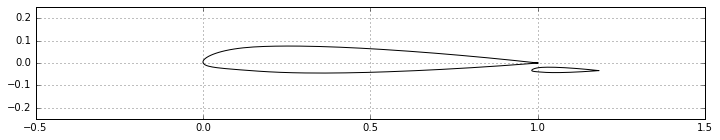

In [6]:
pyplot.figure(figsize=(12,2))
pyplot.plot(x_wing, y_wing, x_flap, y_flap,  color='k', linestyle='-', linewidth=1);
pyplot.grid(True)
panel_main, panel_flap = define_panels(x_wing, y_wing, N2), define_panels(x_flap, y_flap, N2)
pyplot.xlim(-0.5, 1.5)
pyplot.ylim(-0.25, 0.25)

In [8]:
from scipy import integrate

In [12]:
alpha1 = -14.
alpha2 = 14.
li = alpha1 + alpha2
length = (numpy.max(x_wing) - numpy.min(x_wing) + (numpy.max(x_flap) - numpy.min(x_flap)))

xc, yc = 1.03, -0.054
theta_all = [0., 5., 10., 15.]
lift = numpy.empty_like(theta_all)
drag = numpy.empty_like(theta_all)
Lc = numpy.empty_like(theta_all)
loss = numpy.empty_like(theta_all)

In [17]:
for i, theta in enumerate(theta_all):
    lift[i] = 0.
    xfnew, yfnew = theta_rotate(x_flap, y_flap, x_h, y_h, theta)
    panel_main = define_panels(x_wing, y_wing, N2)
    panel_flap = define_panels(xfnew, yfnew, N2)
    panels = numpy.append(panel_main, panel_flap)
    freestream = Freestream(u_inf, 4.)
    A, At = build_matrix(panels)
    b = build_rhs(panels, freestream)
    variables = numpy.linalg.solve(A,b)

    for j, panel in enumerate(panels):
        panel.sigma = variables[j]

    gamma = variables[-2:]
    get_tangential_velocity(panels, freestream, gamma, At)
    get_cp(panels, freestream)

    for panel in panels:
        lift[i] -= panel.cp * panel.length * math.sin(panel.beta)
        drag[i] += panel.cp * panel.length * math.cos(panel.beta)

    Lc[i] = lift[i] / length

C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:191: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:194: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:195: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:200: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\55468\Anaconda3\lib\site-packages\ipykernel\__main__.py:106: VisibleDep

In [18]:
100 * (1 - 1/numpy.sqrt(lift[1] / lift[0]))

14.411837199462829

In [19]:
100 * (1 - 1/numpy.sqrt(lift[2] / lift[0]))

23.766926119193833

In [20]:
100 * (1 - 1/numpy.sqrt(lift[3] / lift[0]))

30.258640252869984